<a href="https://colab.research.google.com/github/tbazzi/Data-Science---Fullstack-Bootcamp/blob/master/S4_Projet_FraudulentActivity_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import seaborn as sns
import pandas as pd
import numpy as np
#import matplotlib as plt
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
data_fraud = pd.read_csv('/content/drive/My Drive/Fraud_Data_withIP.csv')


#Pre-processing et Visualisation

In [4]:
data_fraud = data_fraud.drop("Unnamed: 0", axis=1)
data_fraud.head()


,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,62421,2015-02-16 00:17:05,2015-03-08 10:00:39,46,ZCLZTAJPCRAQX,Direct,Safari,M,36,52093,0,-1
1,173212,2015-03-08 04:03:22,2015-03-20 17:23:45,33,YFGYOALADBHLT,Ads,IE,F,30,93447,0,-1
2,242286,2015-05-17 16:45:54,2015-05-26 08:54:34,33,QZNVQTUITFTHH,Direct,FireFox,F,32,105818,0,-1
3,370003,2015-03-03 19:58:39,2015-05-28 21:09:13,33,PIBUQMBIELMMG,Ads,IE,M,40,117566,0,-1
4,119824,2015-03-20 00:31:27,2015-04-05 07:31:46,55,WFIIFCPIOGMHT,Ads,Safari,M,38,131423,0,-1


Calcul de difference de temps entre d'inscription et temps d'achat

In [5]:
from datetime import datetime
data_fraud["purchase_time"] = data_fraud["purchase_time"].apply(lambda x: int(datetime.timestamp(datetime.strptime(str(x),'%Y-%m-%d %H:%M:%S'))))
data_fraud["signup_time"] = data_fraud["signup_time"].apply(lambda x: int(datetime.timestamp(datetime.strptime(str(x),'%Y-%m-%d %H:%M:%S'))))
#data_fraud["time"] = datetime.timestamp(datetime.strptime(str(data_fraud["purchase_time"]),'%Y-%m-%d %H:%M:%S'))-datetime.timestamp(datetime.strptime(str(data_fraud["signup_time"]),'%Y-%m-%d %H:%M:%S'))
data_fraud.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,62421,1424045825,1425808839,46,ZCLZTAJPCRAQX,Direct,Safari,M,36,52093,0,-1
1,173212,1425787402,1426872225,33,YFGYOALADBHLT,Ads,IE,F,30,93447,0,-1
2,242286,1431881154,1432630474,33,QZNVQTUITFTHH,Direct,FireFox,F,32,105818,0,-1
3,370003,1425412719,1432847353,33,PIBUQMBIELMMG,Ads,IE,M,40,117566,0,-1
4,119824,1426811487,1428219106,55,WFIIFCPIOGMHT,Ads,Safari,M,38,131423,0,-1


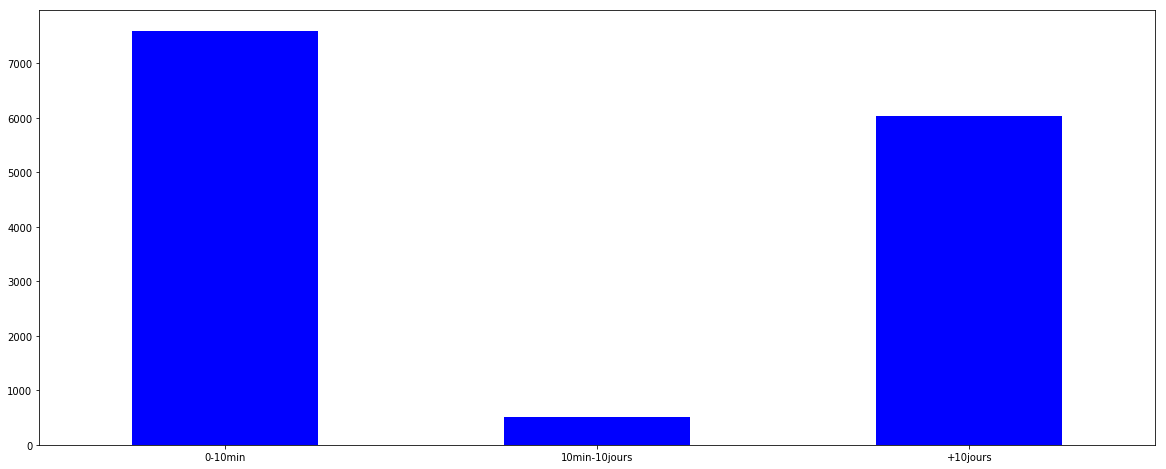

In [8]:
s = data_fraud[data_fraud["class"] == 1] 
s["time_diff"] = (s["purchase_time"]-s["signup_time"])
out = pd.cut(s["time_diff"], bins=[0, 600, 864000, 100000000], include_lowest=True)
ax = out.value_counts(sort=False).plot.bar(rot=0, color="b", figsize=(20,8))
ax.set_xticklabels(["0-10min", "10min-10jours", "+10jours"])#
plt.show()

Inverser la différence de temps pour donner plus de poids aux petites valeurs, puisqu'elle présentent de plus de risque

In [9]:
data_fraud["time"] = 1/(data_fraud["purchase_time"]-data_fraud["signup_time"])
data_fraud.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,time
0,62421,1424045825,1425808839,46,ZCLZTAJPCRAQX,Direct,Safari,M,36,52093,0,-1,5.672105e-07
1,173212,1425787402,1426872225,33,YFGYOALADBHLT,Ads,IE,F,30,93447,0,-1,9.218094e-07
2,242286,1431881154,1432630474,33,QZNVQTUITFTHH,Direct,FireFox,F,32,105818,0,-1,1.334543e-06
3,370003,1425412719,1432847353,33,PIBUQMBIELMMG,Ads,IE,M,40,117566,0,-1,1.345056e-07
4,119824,1426811487,1428219106,55,WFIIFCPIOGMHT,Ads,Safari,M,38,131423,0,-1,7.104195e-07


In [10]:
data_fraud = data_fraud.drop("signup_time", axis=1)
data_fraud = data_fraud.drop("purchase_time", axis=1)
data_fraud = data_fraud.drop("ip_address", axis=1)
data_fraud.head()


,user_id,purchase_value,device_id,source,browser,sex,age,class,country,time
0,62421,46,ZCLZTAJPCRAQX,Direct,Safari,M,36,0,-1,5.672105e-07
1,173212,33,YFGYOALADBHLT,Ads,IE,F,30,0,-1,9.218094e-07
2,242286,33,QZNVQTUITFTHH,Direct,FireFox,F,32,0,-1,1.334543e-06
3,370003,33,PIBUQMBIELMMG,Ads,IE,M,40,0,-1,1.345056e-07
4,119824,55,WFIIFCPIOGMHT,Ads,Safari,M,38,0,-1,7.104195e-07


grouper par device et faire un compteur de nombre de fraudes

In [0]:
data_grouped_device = pd.DataFrame(data_fraud.groupby(["device_id", "class"]).size().reset_index(name='count'))
devices = data_grouped_device[data_grouped_device["class"] == 1]
data_fraud["device_fraud"] =""
for d in devices.values:
  indexNames = data_fraud[data_fraud.device_id == d[0]].index
  data_fraud.loc[indexNames, "device_fraud"] = int(d[2])


In [12]:
data_fraud["device_fraud"] = data_fraud["device_fraud"].apply(lambda x : int(x) if x !='' else 0)
data_fraud.head()

,user_id,purchase_value,device_id,source,browser,sex,age,class,country,time,device_fraud
0,62421,46,ZCLZTAJPCRAQX,Direct,Safari,M,36,0,-1,5.672105e-07,0
1,173212,33,YFGYOALADBHLT,Ads,IE,F,30,0,-1,9.218094e-07,0
2,242286,33,QZNVQTUITFTHH,Direct,FireFox,F,32,0,-1,1.334543e-06,0
3,370003,33,PIBUQMBIELMMG,Ads,IE,M,40,0,-1,1.345056e-07,0
4,119824,55,WFIIFCPIOGMHT,Ads,Safari,M,38,0,-1,7.104195e-07,0


In [0]:
data_fraud = data_fraud.drop("device_id", axis=1)

Tester s'il y a un impact du user id sur le risque de fraude

In [14]:
data_grouped_user = pd.DataFrame(data_fraud.groupby(["user_id", "class"]).size().reset_index(name='count'))
users = data_grouped_user[data_grouped_user["class"] == 1]
users[users["count"]>1]

,user_id,class,count


In [15]:
data_fraud = data_fraud.drop("user_id", axis=1)
data_fraud.head()

,purchase_value,source,browser,sex,age,class,country,time,device_fraud
0,46,Direct,Safari,M,36,0,-1,5.672105e-07,0
1,33,Ads,IE,F,30,0,-1,9.218094e-07,0
2,33,Direct,FireFox,F,32,0,-1,1.334543e-06,0
3,33,Ads,IE,M,40,0,-1,1.345056e-07,0
4,55,Ads,Safari,M,38,0,-1,7.104195e-07,0


grouper par valeur d'achat pour voir s'il y a un pattern

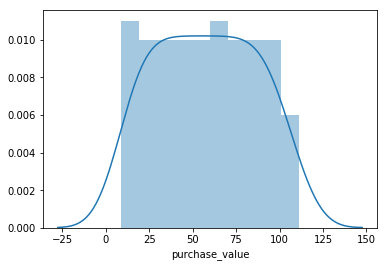

In [16]:
data_grouped_pv = pd.DataFrame(data_fraud.groupby(["purchase_value", "class"]).size().reset_index(name='count'))
pv = data_grouped_pv[data_grouped_pv["class"] == 1]
pv = pv.sort_values(by = "purchase_value", ascending= False)
sns.distplot(pv.purchase_value, bins = 10)

Grouper les fraudes par pays 

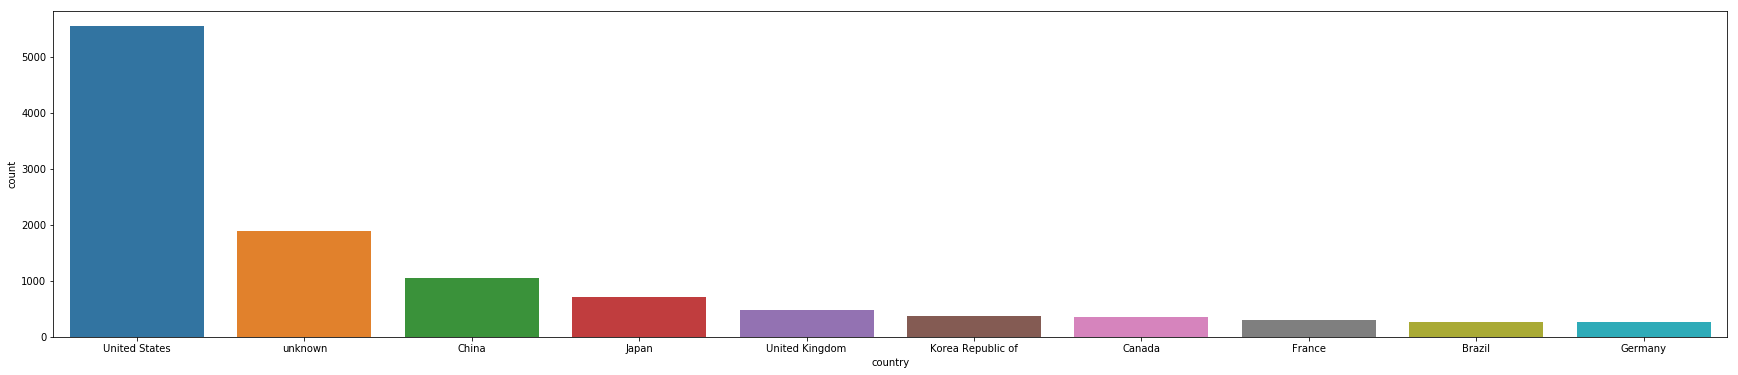

In [17]:
data_fraud.country = data_fraud.country.apply(lambda x: "unknown" if x == '-1' else x)
data_grouped_coun = pd.DataFrame(data_fraud.groupby(["country","class"]).size().reset_index(name='count'))
data_grouped_coun = data_grouped_coun[data_grouped_coun["class"] == 1]

data_fraud["coun_freq"] =""
for d in data_grouped_coun.values:
  indexNames = data_fraud[data_fraud.country == d[0]].index
  data_fraud.loc[indexNames, "coun_freq"] = int(d[2])

data_grouped_coun = data_grouped_coun.sort_values(by = "count", ascending=False)
plt.figure(figsize=(30,6))
sns.barplot(x = "country", y = "count", data = data_grouped_coun.iloc[:10,:])


In [18]:
data_fraud.head()

,purchase_value,source,browser,sex,age,class,country,time,device_fraud,coun_freq
0,46,Direct,Safari,M,36,0,unknown,5.672105e-07,0,1883
1,33,Ads,IE,F,30,0,unknown,9.218094e-07,0,1883
2,33,Direct,FireFox,F,32,0,unknown,1.334543e-06,0,1883
3,33,Ads,IE,M,40,0,unknown,1.345056e-07,0,1883
4,55,Ads,Safari,M,38,0,unknown,7.104195e-07,0,1883


In [19]:
data_fraud = data_fraud.drop("country", axis=1)
data_fraud.head()

,purchase_value,source,browser,sex,age,class,time,device_fraud,coun_freq
0,46,Direct,Safari,M,36,0,5.672105e-07,0,1883
1,33,Ads,IE,F,30,0,9.218094e-07,0,1883
2,33,Direct,FireFox,F,32,0,1.334543e-06,0,1883
3,33,Ads,IE,M,40,0,1.345056e-07,0,1883
4,55,Ads,Safari,M,38,0,7.104195e-07,0,1883


In [0]:
'''from sklearn import preprocessing
le = preprocessing.LabelEncoder()
cols = ["source",	"browser",	"sex"]
for y in cols:
  le.fit(data_fraud[y])
  data_fraud[y] = le.transform(data_fraud[y])
data_fraud.head()'''

In [20]:
data_fraud.isna().any()

purchase_value    False
source            False
browser           False
sex               False
age               False
class             False
time              False
device_fraud      False
coun_freq         False
dtype: bool

Dummification

In [0]:
data_fraud_dumm = pd.get_dummies(data_fraud, drop_first=True)


In [22]:
data_fraud_dumm.head()

,purchase_value,age,class,time,device_fraud,source_Direct,source_SEO,browser_FireFox,browser_IE,browser_Opera,browser_Safari,sex_M,coun_freq_2,coun_freq_3,coun_freq_4,coun_freq_5,coun_freq_6,coun_freq_7,coun_freq_8,coun_freq_10,coun_freq_11,coun_freq_12,coun_freq_13,coun_freq_14,coun_freq_16,coun_freq_18,coun_freq_19,coun_freq_21,coun_freq_27,coun_freq_28,coun_freq_31,coun_freq_33,coun_freq_34,coun_freq_36,coun_freq_37,coun_freq_39,coun_freq_42,coun_freq_44,coun_freq_48,coun_freq_50,coun_freq_55,coun_freq_56,coun_freq_57,coun_freq_61,coun_freq_62,coun_freq_64,coun_freq_66,coun_freq_69,coun_freq_73,coun_freq_74,coun_freq_78,coun_freq_79,coun_freq_99,coun_freq_123,coun_freq_131,coun_freq_134,coun_freq_144,coun_freq_151,coun_freq_165,coun_freq_166,coun_freq_262,coun_freq_270,coun_freq_300,coun_freq_348,coun_freq_380,coun_freq_477,coun_freq_715,coun_freq_1043,coun_freq_1883,coun_freq_5551,coun_freq_
0,46,36,0,5.672105e-07,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,33,30,0,9.218094e-07,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,33,32,0,1.334543e-06,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,33,40,0,1.345056e-07,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,55,38,0,7.104195e-07,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


Normaliser valeur d'achat, age et difference de temps

In [34]:
from sklearn.preprocessing import StandardScaler
sc_x = StandardScaler()
#X = data_fraud[["user_id", "purchase_value", "device_id", "source", "browser", "sex", "age", "country", "time"]]
X = data_fraud_dumm[[ "purchase_value", "age", "time", "device_fraud"]]
X = sc_x.fit_transform(X)
X = pd.DataFrame(X, columns=[ "purchase_value", "age", "time", "device_fraud"])
X = X.join(data_fraud_dumm.iloc[:,5:])
X.head()

,purchase_value,age,time,device_fraud,source_Direct,source_SEO,browser_FireFox,browser_IE,browser_Opera,browser_Safari,sex_M,coun_freq_2,coun_freq_3,coun_freq_4,coun_freq_5,coun_freq_6,coun_freq_7,coun_freq_8,coun_freq_10,coun_freq_11,coun_freq_12,coun_freq_13,coun_freq_14,coun_freq_16,coun_freq_18,coun_freq_19,coun_freq_21,coun_freq_27,coun_freq_28,coun_freq_31,coun_freq_33,coun_freq_34,coun_freq_36,coun_freq_37,coun_freq_39,coun_freq_42,coun_freq_44,coun_freq_48,coun_freq_50,coun_freq_55,coun_freq_56,coun_freq_57,coun_freq_61,coun_freq_62,coun_freq_64,coun_freq_66,coun_freq_69,coun_freq_73,coun_freq_74,coun_freq_78,coun_freq_79,coun_freq_99,coun_freq_123,coun_freq_131,coun_freq_134,coun_freq_144,coun_freq_151,coun_freq_165,coun_freq_166,coun_freq_262,coun_freq_270,coun_freq_300,coun_freq_348,coun_freq_380,coun_freq_477,coun_freq_715,coun_freq_1043,coun_freq_1883,coun_freq_5551,coun_freq_
0,0.494721,0.331793,-0.230127,-0.256068,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,-0.214781,-0.364448,-0.230125,-0.256068,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,-0.214781,-0.132367,-0.230123,-0.256068,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,-0.214781,0.795954,-0.230129,-0.256068,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,0.985915,0.563874,-0.230126,-0.256068,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [35]:
from sklearn.preprocessing import KBinsDiscretizer
est = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='quantile')
est.fit(X)

KBinsDiscretizer(encode='ordinal', n_bins=3, strategy='quantile')

In [0]:
from sklearn.model_selection import train_test_split
y  = data_fraud["class"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42, stratify = y)

In [42]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
parameters = {
    'n_estimators'      : np.arange(1,2),
    'max_depth'         : [8, 9, 10, 11, 12],
    'random_state'      : [0],
    'max_features': ['auto'],
    'criterion' :['gini']
}

clfG = GridSearchCV(RandomForestClassifier(), parameters, cv=10, n_jobs=-1)
clfG.fit(X_train, y_train)



0.9808532227467243
{'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 1, 'random_state': 0}


In [44]:
print(clfG.best_estimator_.score(X_test, y_test))
print(clfG.best_params_)


0.9808532227467243
{'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 1, 'random_state': 0}


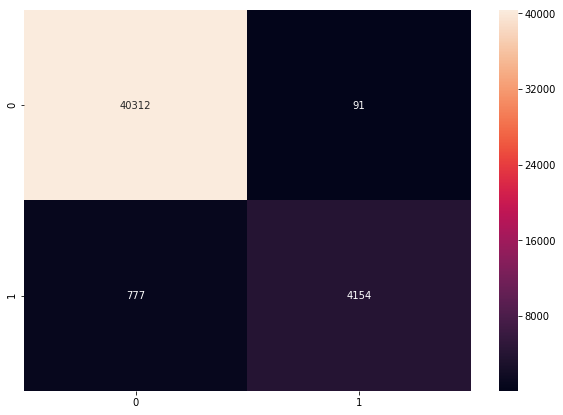

In [45]:
from sklearn.metrics import confusion_matrix
y_pred = clfG.best_estimator_.predict(X_test)
cm = confusion_matrix(y_pred, y_test )
fig, ax = plt.subplots(figsize=(10,7))  
sns.heatmap(cm, annot=True, fmt="d", ax = ax)

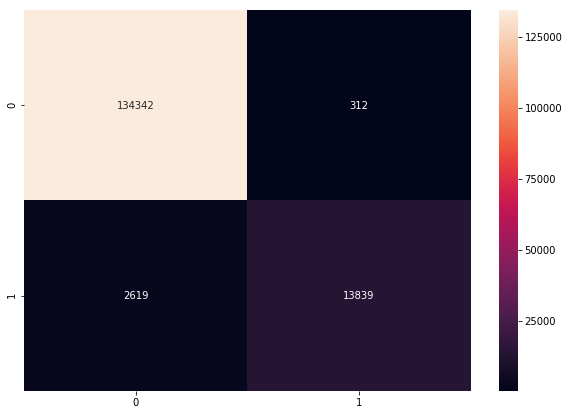

In [46]:
y_pred = clfG.best_estimator_.predict(X)
cm = confusion_matrix(y_pred, y)
fig, ax = plt.subplots(figsize=(10,7))  
sns.heatmap(cm, annot=True, fmt="d", ax = ax)

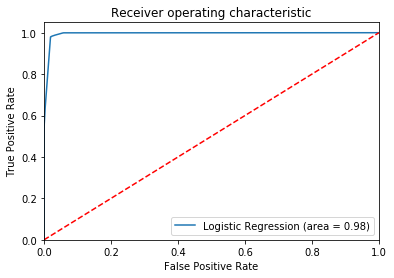

In [47]:
#ROC-AUC
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(y, clfG.best_estimator_.predict(X))
fpr, tpr, thresholds = roc_curve(y, clfG.best_estimator_.predict_proba(X)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

On essaye avec la méthode Bagging pour réduire les faux négatifs

In [0]:
from sklearn.ensemble import BaggingClassifier as BC

rfc = RandomForestClassifier()
modelB = BC(base_estimator = rfc, n_estimators = 100, warm_start = True, bootstrap_features=True, max_samples=0.9)

#param_grid = {
#    'base_estimator__max_depth' : [1, 2, 3, 4, 5],
#    'max_samples' : [0.05, 0.1, 0.2, 0.5]
#}

#clf = GridSearchCV(BC(rfc,n_estimators = 100, max_features = 0.5),param_grid)
#clf.fit(X_train, y_train)

modelB_fit = modelB.fit(X_train,y_train)



In [69]:
print(modelB_fit.score(X_test,y_test))


0.975868001941148


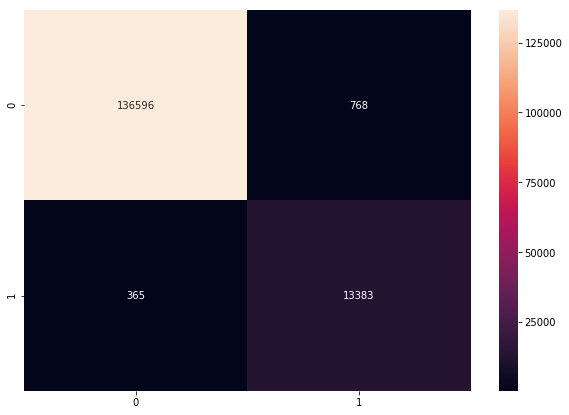

In [70]:
from sklearn.metrics import confusion_matrix
y_pred = modelB_fit.predict(X)
cm = confusion_matrix(y_pred, y)
fig, ax = plt.subplots(figsize=(10,7))  
sns.heatmap(cm, annot=True, fmt="d", ax = ax)

On teste un XGBoost classifier pour voir si ça améliore la prédiction

In [72]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
xgb.score(X_test, y_test)

0.9867649005161688

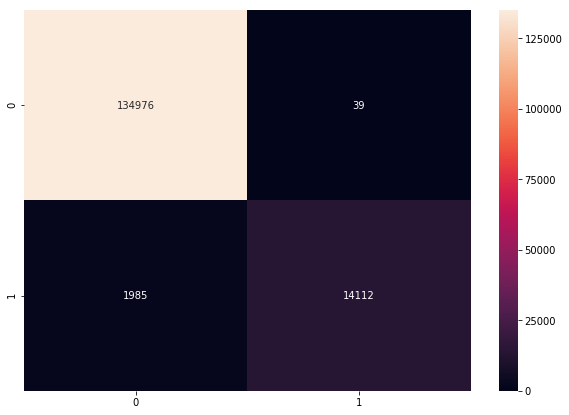

In [73]:
from sklearn.metrics import confusion_matrix
y_pred = xgb.predict(X)
cm = confusion_matrix(y_pred, y)
fig, ax = plt.subplots(figsize=(10,7))  
sns.heatmap(cm, annot=True, fmt="d", ax = ax)